In [877]:
import datetime, urllib, re, math, json, requests,io
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML



try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

In [878]:
#* constants



#** pandas
# change max number of rows to show
pd.set_option('display.max_rows', 300)

#** plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler
#* dpi size
plt.rcParams['figure.dpi'] = 200
myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

# real time data, from a spin of JHU
http://blog.lazd.net/coronadatascraper/

In [879]:
df = pd.read_csv("http://blog.lazd.net/coronadatascraper/data.csv",parse_dates=True)
dataCS =df.set_index(["city","county","state","country"])


#use index slice for more easy/clean access
idx = pd.IndexSlice

IClmns= idx["cases","death","recovered","tested",'url']


ctrMask = dataCS["cases"] > 1000
dataCS.loc[idx[:,:, :, ctrMask],:].sort_values(by="cases",ascending=False)

cases  deaths  recovered  tested  \
city county state               country                                     
NaN  NaN    Hubei               CHN      67799  3111.0    56003.0     NaN   
            NaN                 ITA      31506  2503.0     2941.0     NaN   
            Lombardia           ITA      16220  1640.0     2485.0     NaN   
            NaN                 IRN      16169   988.0     5389.0     NaN   
                                ESP      11178   491.0        2.0     NaN   
                                DEU       9257    24.0       67.0     NaN   
                                KOR       8320    81.0     1407.0     NaN   
                                FRA       7730     NaN        NaN     NaN   
            Comunidad de Madrid ESP       4871   355.0        0.0     NaN   
            Emilia Romagna      ITA       3931   393.0      134.0     NaN   
            Veneto              ITA       2704    80.0      136.0     NaN   
            NaN                 CHE       2700    27.0        4.0     NaN   
            Ile-de-France       FRA       2177     0.0        NaN     NaN   
            NaN                 GBR       1950    55.0       52.0     NaN   
            Piemonte            ITA       1897   133.0        0.0     NaN   
            Grand Est           FRA       1820     0.0        NaN     NaN   
            NaN                 NOR       1463     3.0        1.0     NaN   
            Cataluña            ESP       1394    18.0        0.0     NaN   
            NY                  USA       1374     NaN        NaN     NaN   
            Marche              ITA       1371    69.0        0.0     NaN   
            Guangdong           CHN       1364     8.0     1307.0     NaN   
            NaN                 AUT       1332     3.0        1.0     NaN   
            Henan               CHN       1273    22.0     1250.0     NaN   
            NaN                 BEL       1243    10.0        1.0     NaN   
            Zhejiang            CHN       1232     1.0     1216.0     NaN   
            NaN                 SWE       1190     7.0        1.0     NaN   
            Toscana             ITA       1053    17.0       12.0     NaN   
            Hunan               CHN       1018     4.0     1014.0     NaN   
            WA                  USA       1012    52.0        NaN     NaN   

                                         active   population        lat  \
city county state               country                                   
NaN  NaN    Hubei               CHN        8685   59170000.0  31.166405   
            NaN                 ITA       26062   62137802.0  41.826062   
            Lombardia           ITA       12095   10060574.0  45.657567   
            NaN                 IRN        9792   82021564.0  32.412651   
                                ESP       10685   48958159.0  35.738471   
                                DEU        9166   80594017.0  51.099245   
                                KOR        6832   51181299.0  35.912360   
                                FRA        7730   67106161.0  14.862001   
            Comunidad de Madrid ESP        4516          NaN        NaN   
            Emilia Romagna      ITA        3404    4459477.0  44.435519   
            Veneto              ITA        2488    4905854.0  45.737147   
            NaN                 CHE        2669    8236303.0  46.840811   
            Ile-de-France       FRA        2177          NaN        NaN   
            NaN                 GBR        1843   64769452.0  55.191616   
            Piemonte            ITA        1764    4356406.0  45.261022   
            Grand Est           FRA        1820          NaN        NaN   
            NaN                 NOR        1459    5320045.0  69.255255   
            Cataluña            ESP        1376          NaN  42.035626   
            NY                  USA        1374   19453561.0  -3.095310   
            Marche              ITA        1302    1525271.0  43.327896   
   

In [880]:
idx = pd.IndexSlice

# must have colons liberally used, firt two colons for city/county and last colon for all columns
#option 1 for access
dataCS.loc[(np.nan, "Los Angeles County", "CA", "USA")]
#option 2 for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
dataCS.loc[idx[:, "San Diego County", "CA", "USA"],IClmns]
#total cases in ca
dataCS.loc[idx[np.nan, np.nan, "CA", "USA"],:]["cases"]
display(HTML(dataCS.loc[idx[:, :, "CA", "USA"],IClmns].to_html()))

dataCS.loc[idx[:, "San Diego County", "CA", "USA"],["url"]].values

array([['https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html']],
      dtype=object)

# CDC Data is here:

html --> https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html    
json --> https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json

In [881]:
#using cdc data direclty for the US


url = "https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json"

r = requests.get(url)
jdata =r.json()

# get x/y's
x = jdata["data"]["columns"][0][1:]
X = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in x] # x's
v = jdata["data"]["columns"][1][1:] # v's (new cases fo the day)

# interpolate the zeros, since nearly impossible to have no growth
V = pd.Series(np.array(v).astype('int'))
V[V==0]=np.nan #
V = V.interpolate()
if(0): #check data
    print(list(zip(X,V)))
# Remove fist zeros
offsetZero = V.notna().idxmax()
V = V.values[offsetZero:]
X = X[offsetZero:]    

# convert new cases (v) to cumulative cases(y)
dataCdc = pd.Series(V,X).cumsum()



# john hopkins data base
## gui 

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

## githunb 

https://github.com/CSSEGISandData/COVID-19

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series

In [912]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids, set Na for np.NaN (very annoying)
df["Province/State"]=df["Province/State"].fillna("NA")
df =df.set_index(["Country/Region","Lat","Long","Province/State"])


df.columns = pd.to_datetime(df.columns,format="%m/%d/%y")

dt = df.columns[-1]
print(dt)
if sum(df[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data = df.drop(columns=dt)    
    dt = df.columns[-2]
else:
    data = df
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
euro      = ["Germany","DenMark","France","Italy","Sweden","Switzerland",
             "Spain","Portugal","Belgium","Iceland","Ireland","Netherlands"]

data.loc["NoChina",np.NaN,np.NaN,"NA"]=data.loc[(noChin)].sum()    
data.loc[("Europe",np.NaN,np.NaN,"NA")]=data.loc[euro].sum()    
# note this is an over-estimate
data.loc[("USAll",np.NaN,np.NaN,"NA")]=data.loc["US"].sum()    

data.loc[("ChinaAll",np.NaN,np.NaN,"NA")]=data.loc["China"].sum()  
dataJHU = data

2020-03-17 00:00:00


In [883]:
N=1500
# find rows with NA for province/state
g =data.filter(like="NA",axis=0)
# find countries with large case counts
g=g.loc[(g[dt]>N)]

#g = g.loc[(g[dt]>1000),(data.columns[-1],data.columns[-2])]
#d = pd.DataFrame(g.loc[:,(data.columns[-1])]-g.loc[:,data.columns[-2]],columns=["delta"])
#display_side_by_side(g,d)
dataFocus = pd.DataFrame()
dataFocus[data.columns[-1]] = g.loc[(g[dt]>N),(data.columns[-1])]
dataFocus[data.columns[-2]] = g.loc[(g[dt]>N),(data.columns[-2])]
dataFocus["delta"]          = g.loc[:,(data.columns[-1])]-g.loc[:,data.columns[-2]]

dataFocus=dataFocus.reset_index().drop(columns=["Lat",'Long',"Province/State"]).set_index("Country/Region")

display(HTML(dataFocus.sort_values(by="delta",ascending=False).to_html()))


# create list of countires to focus on for later processing
countriesFocused = [data.index.levels[0][i] for i in g.index.labels[0]]
data[data[dt]>1500]
countriesFocused = countriesFocused+["France","United Kingdom"]



,2020-03-17 00:00:00,2020-03-16 00:00:00,delta
Country/Region,,,
NoChina,116087,100497,15590
Europe,67942,58317,9625
Italy,31506,27980,3526
Germany,9257,7272,1985
Spain,11748,9942,1806
USAll,6421,4632,1789
Iran,16169,14991,1178
Switzerland,2700,2200,500
"Korea, South",8320,8236,84


# Covid tracking

https://covidtracking.com

In [902]:
def get_csv_from_url(link):
    response = requests.get(link)
    
    file_object = io.StringIO(response.content.decode('utf-8'))
    return pd.read_csv(file_object)
#not PosNeg is total count subtracting pending

# us daily data -->
links=\
 ["https://covidtracking.com/api/us.csv",     # US current
 "http://covidtracking.com/api/us/daily.csv", # time series  
 "https://covidtracking.com/api/states.csv",  # state current
  "https://covidtracking.com/api/states/daily.csv"] # state time series

# how to get state data time series -->
# "https://covidtracking.com/api/states/daily?state=CA",#states
# "https://covidtracking.com/api/states/daily?state=NY",
dataCovTr = get_csv_from_url(links[0]);
dfUST     = get_csv_from_url(links[1]);
dfStates  = get_csv_from_url(links[2]);
dfTStates  = get_csv_from_url(links[3]);

# remove na from us time  series
dfUST["Case D"]=dfUST["positive"].diff().fillna(-1)
dfUST["Test D"]=dfUST["total"].diff().fillna(-1)
ts = pd.to_datetime(dfUST["date"],format="%Y%m%d")
dfUST.drop("date",axis=1,inplace=True)
dfUST =dfUST.set_index(ts)
# add negative rate for states current
dfStates["NegRate%"]=dfStates["negative"]/dfStates["total"] * 100

print("US Test Data")
display(HTML(dataCovTr.to_html()))
display(HTML(dfUST.sort_values(by="date",ascending=False).head(5).to_html()))
display(HTML(dfStates.sort_values(by="positive",ascending=False).head(5).to_html()))


US Test Data


,positive,negative,posNeg,pending,death,total
0,7731,66225,73956,2538,112,76495


,states,positive,negative,posNeg,pending,death,total,Case D,Test D
date,,,,,,,,,
2020-03-18,56,7731,66225,73956,2538,112.0,76495,2008.0,22410.0
2020-03-17,56,5723,47604,53327,815,90.0,54085,1704.0,12535.0
2020-03-16,56,4019,35840,39859,1691,71.0,41550,846.0,13587.0
2020-03-15,51,3173,22548,25721,2242,60.0,27963,723.0,7168.0
2020-03-14,51,2450,17107,19557,1236,49.0,20795,528.0,4230.0


,state,positive,negative,pending,death,total,lastUpdateEt,checkTimeEt,NegRate%
37,NY,2382,12215.0,NaN,12.0,14597,3/18 15:05,3/18 15:54,83.681578
52,WA,1012,13117.0,NaN,52.0,14129,3/17 18:15,3/18 15:15,92.837427
5,CA,611,7981.0,NaN,13.0,8592,3/17 21:00,3/18 16:26,92.888734
34,NJ,427,190.0,21.0,5.0,638,3/17 13:00,3/18 15:23,29.780564
10,FL,314,1225.0,954.0,7.0,2493,3/18 11:00,3/18 15:26,49.137585


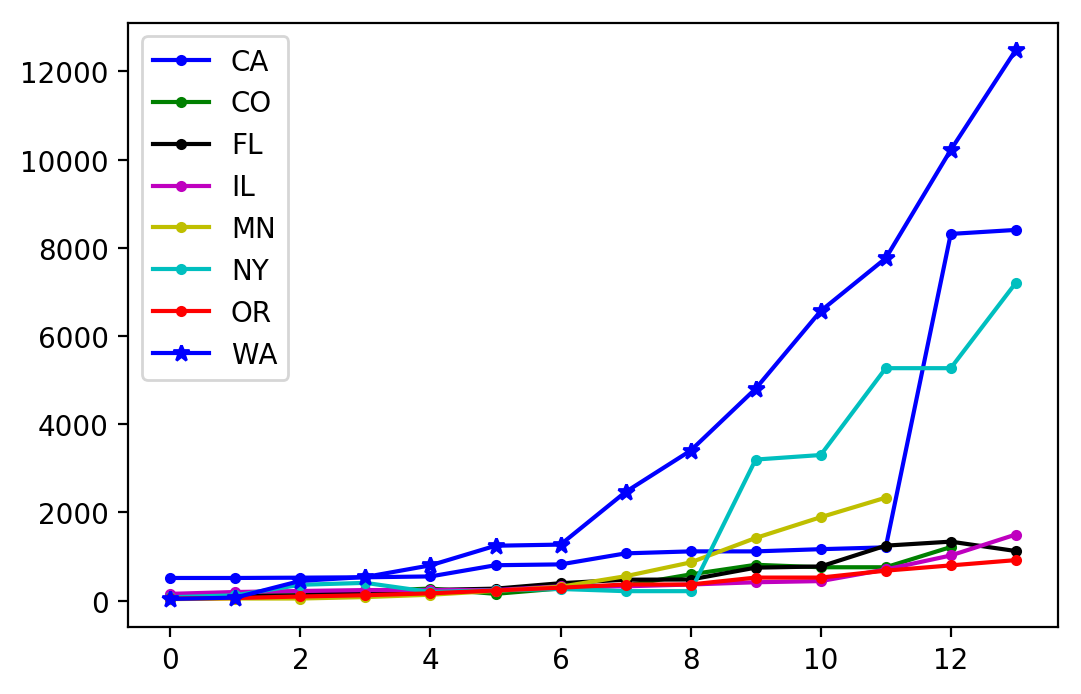

In [862]:
for st in dfTStates["state"].unique():
    if dfTStates[dfTStates["state"]==st]["total"].sum() < 5000: continue
    y = dfTStates[dfTStates["state"]==st].sort_values(by='date',ascending=True)["total"].values
    plt.plot(y,label=st)
plt.legend()



In [863]:
# create new groups
# dont use string for UR, but the 50 states

northAmer = ["US","Canada","Mexico"],
asia      = ["South Korea","Taiwan","Japan"]   
middleEast=["Iraq","Egypt","Iran"]
countries={ "NoChina":"NoChina",
            "North America":northAmer,
            "Europe":"Europe",            
            "middle east":middleEast,
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


Growth Rate NoChina:1.14
Growth Rate China:1.06
Growth Rate Korea, South:1.11
Growth Rate Europe:1.17


<Figure size 1200x800 with 0 Axes>

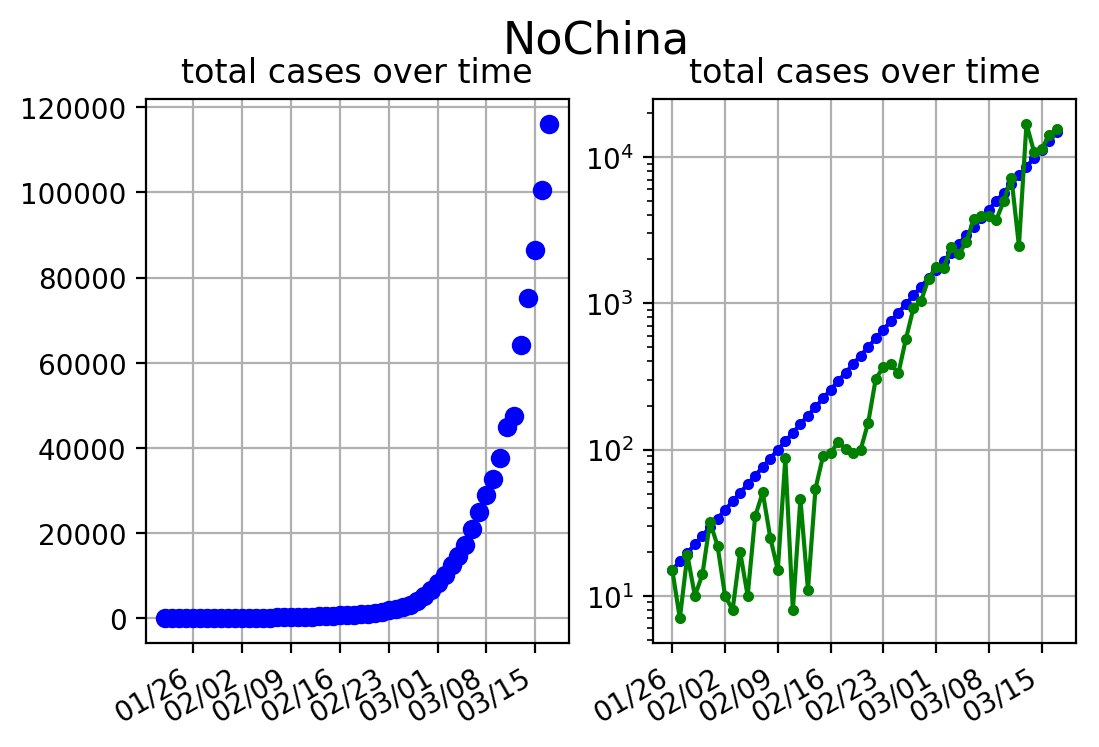

<Figure size 1200x800 with 0 Axes>

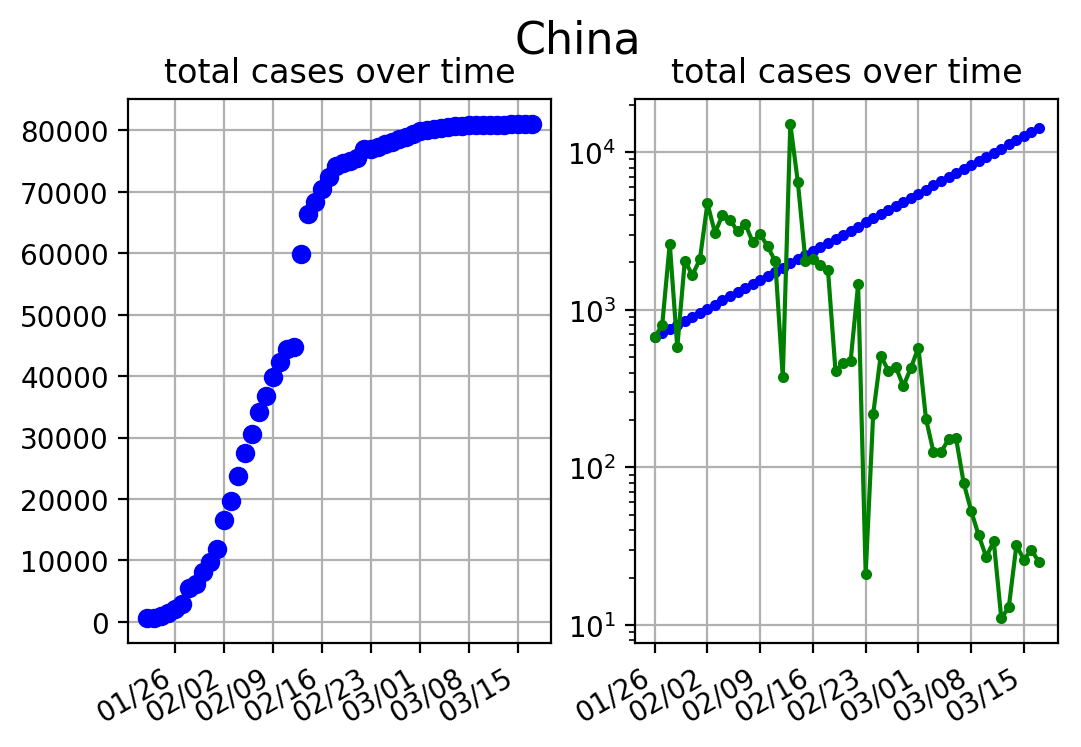

<Figure size 1200x800 with 0 Axes>

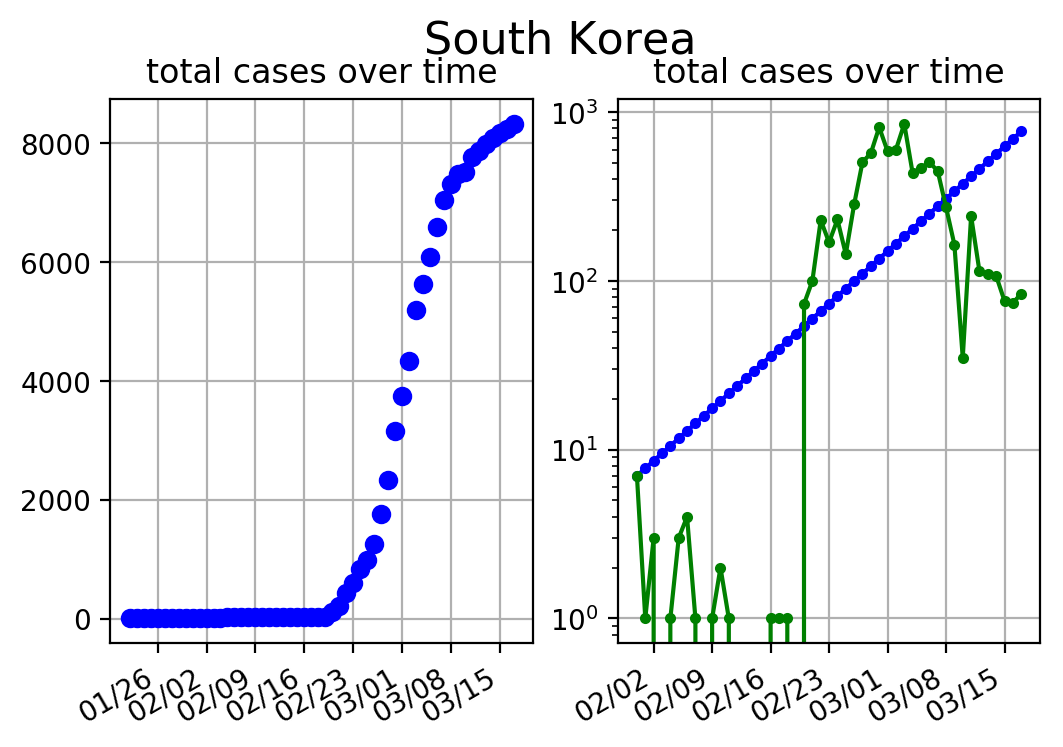

<Figure size 1200x800 with 0 Axes>

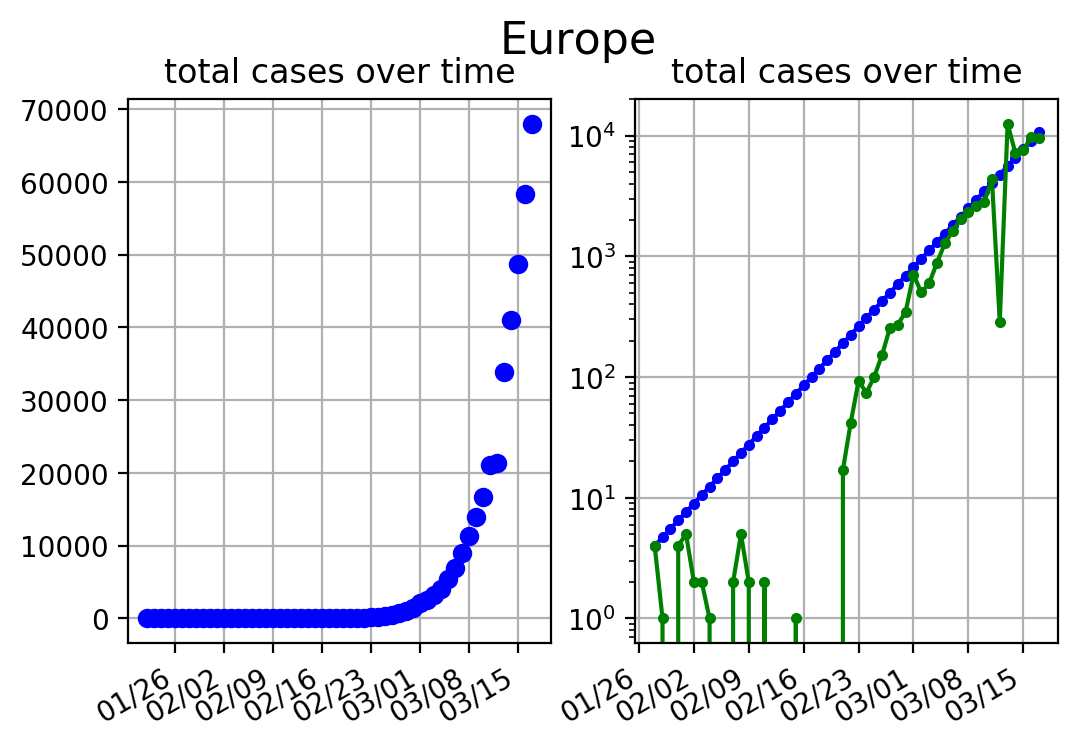

In [864]:
#assume (1+E*P) is 120%


#determine slope and plot
for name in ["NoChina","China", "South Korea", "Europe"]:
    ctr = countries[name]
    plt.figure()
    vals= data.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    ax[1].grid()
#    ax[1].legend()
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].set_title("total cases over time");

    fig.autofmt_xdate()
    
    #---
    y=data.loc[ctr].sum()
    ax[0].plot_date(y.index,y.values)        
    ax[0].grid()
#    ax[0].legend()
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].set_title("total cases over time");

    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


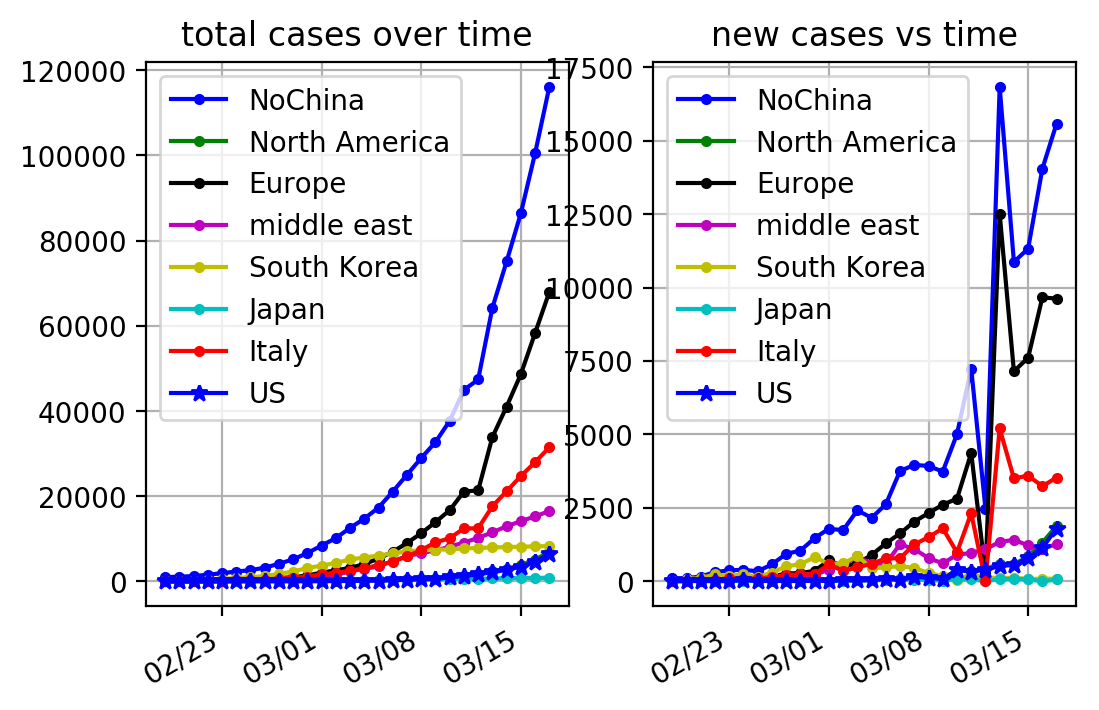

In [865]:
offset=28
#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    y = data.loc[(country)].sum()
    ax[0].plot(y.index[offset:],y.values[offset:],label=name)
#ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].xaxis.set_major_locator(myLocator)
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals[offset:],label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].legend()
ax[1].set_title("new cases vs time");

fig.autofmt_xdate()



# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

[ The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far. ]


A3date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


<Figure size 1200x800 with 0 Axes>

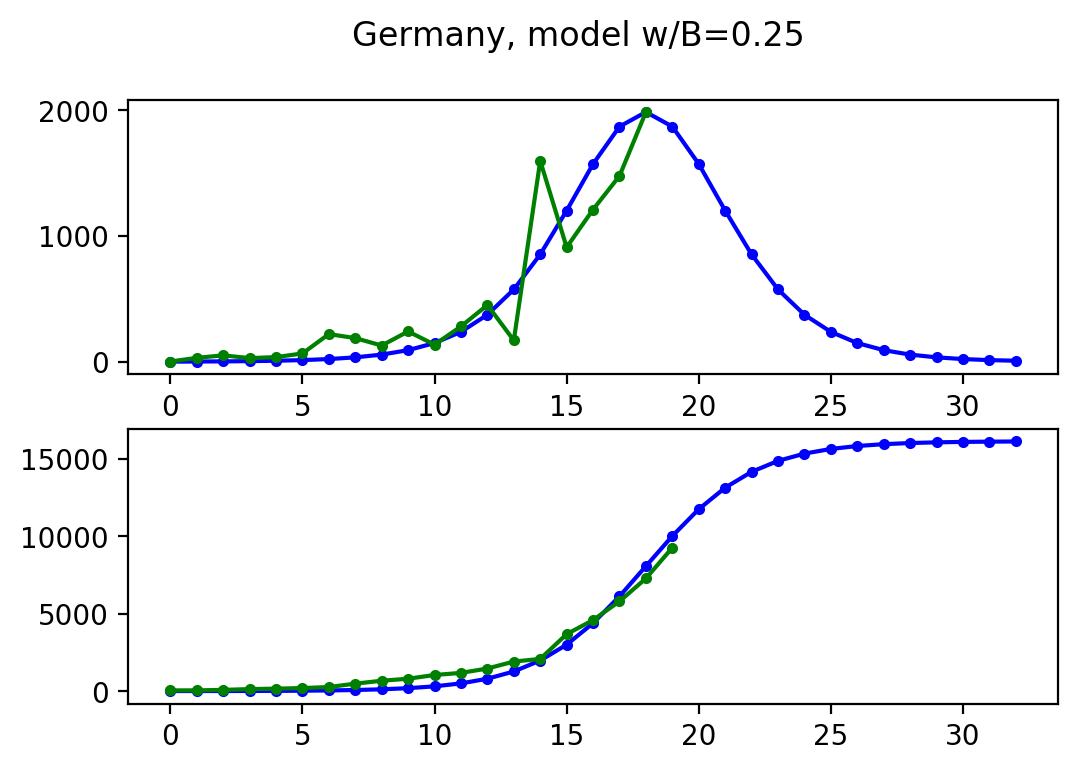

<Figure size 1200x800 with 0 Axes>

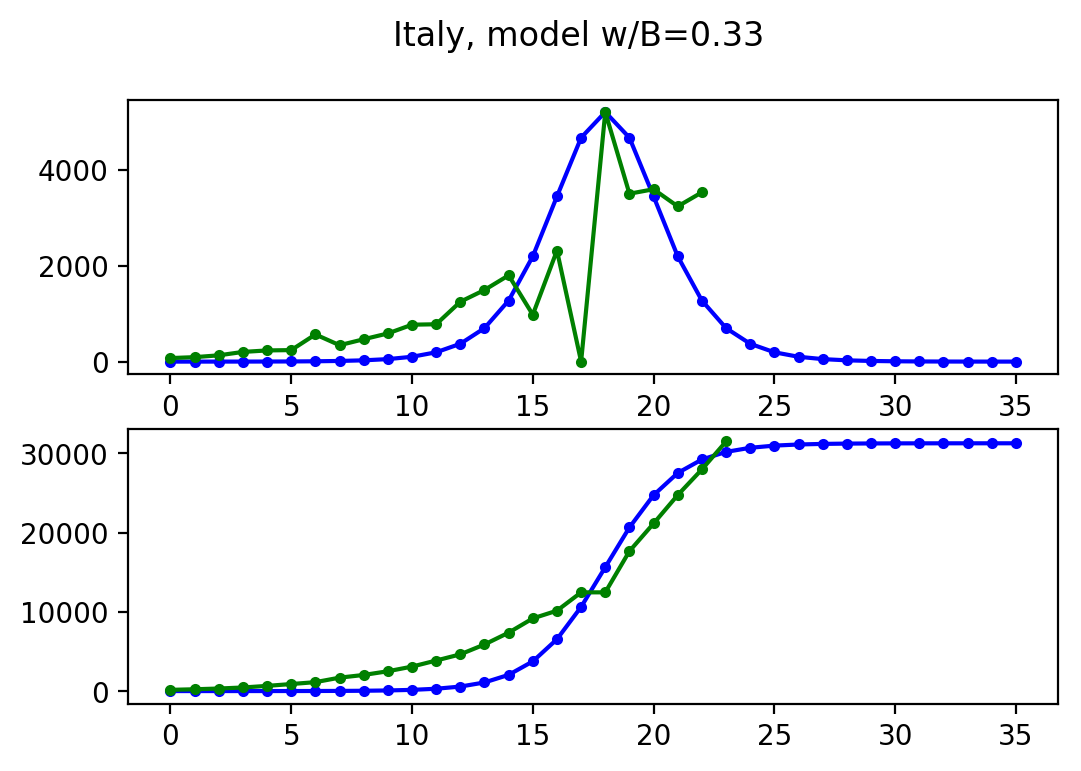

<Figure size 1200x800 with 0 Axes>

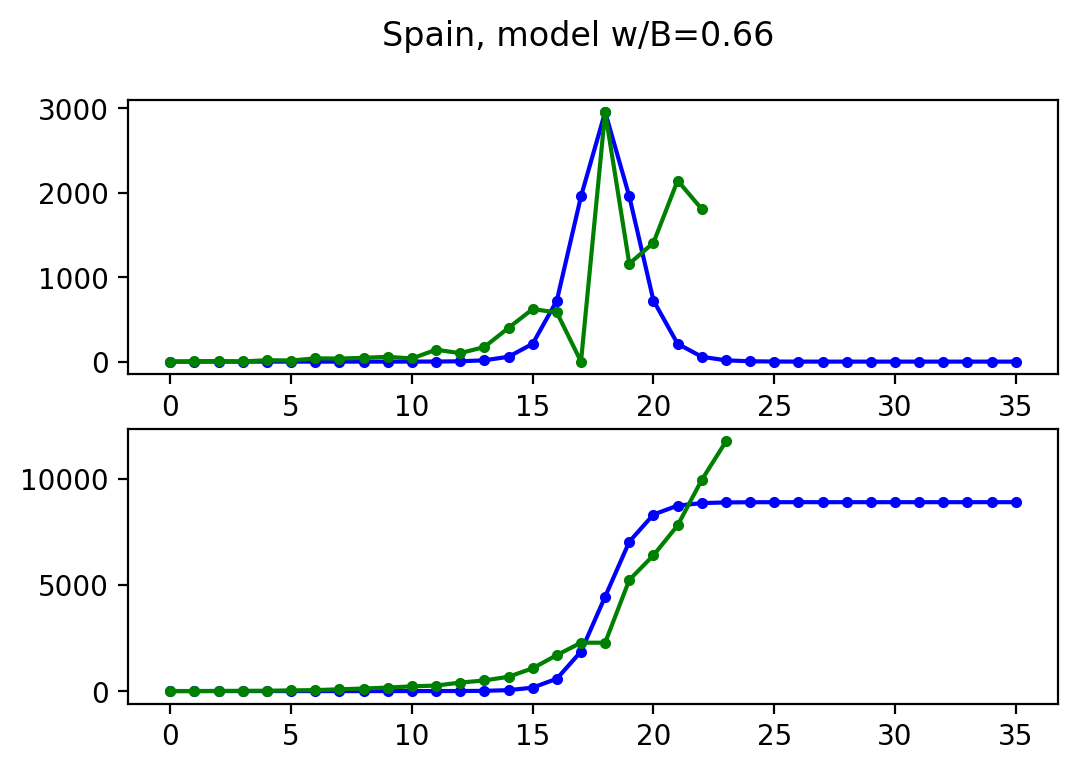

<Figure size 1200x800 with 0 Axes>

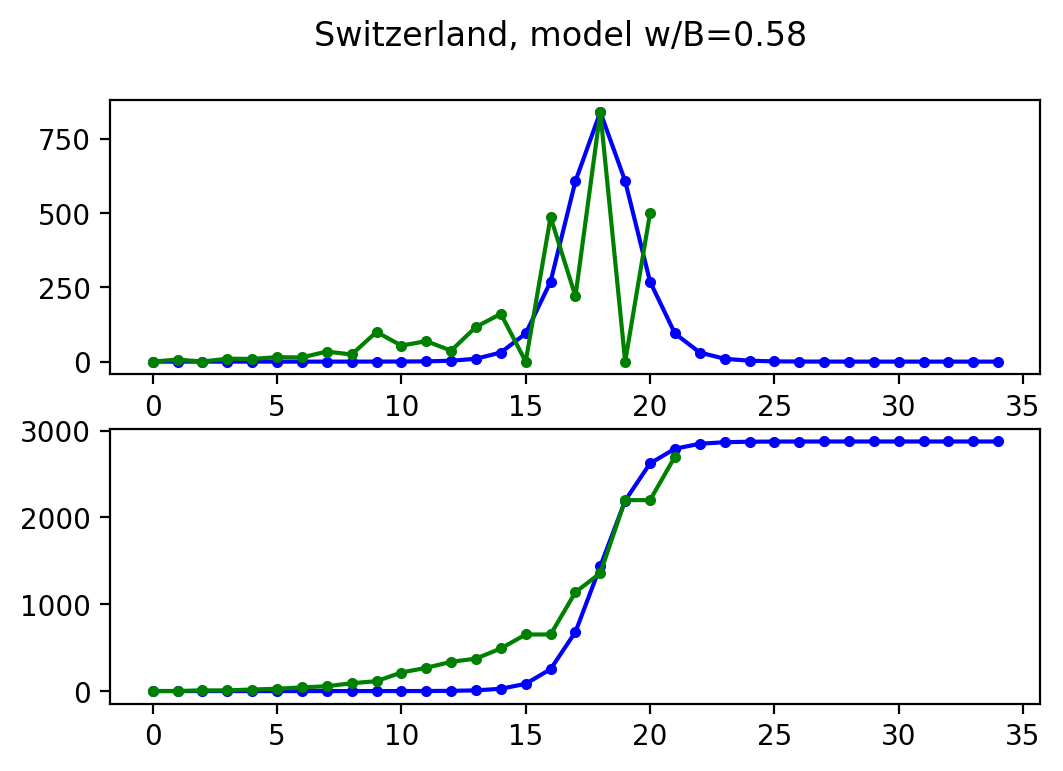

<Figure size 1200x800 with 0 Axes>

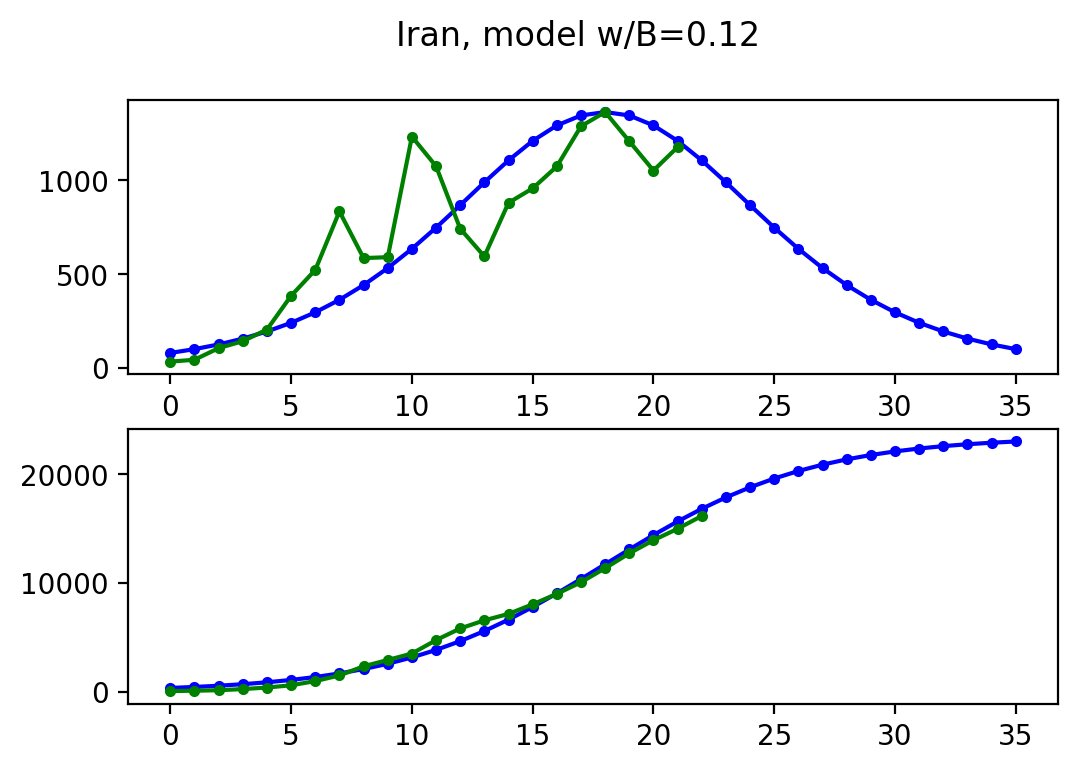

<Figure size 1200x800 with 0 Axes>

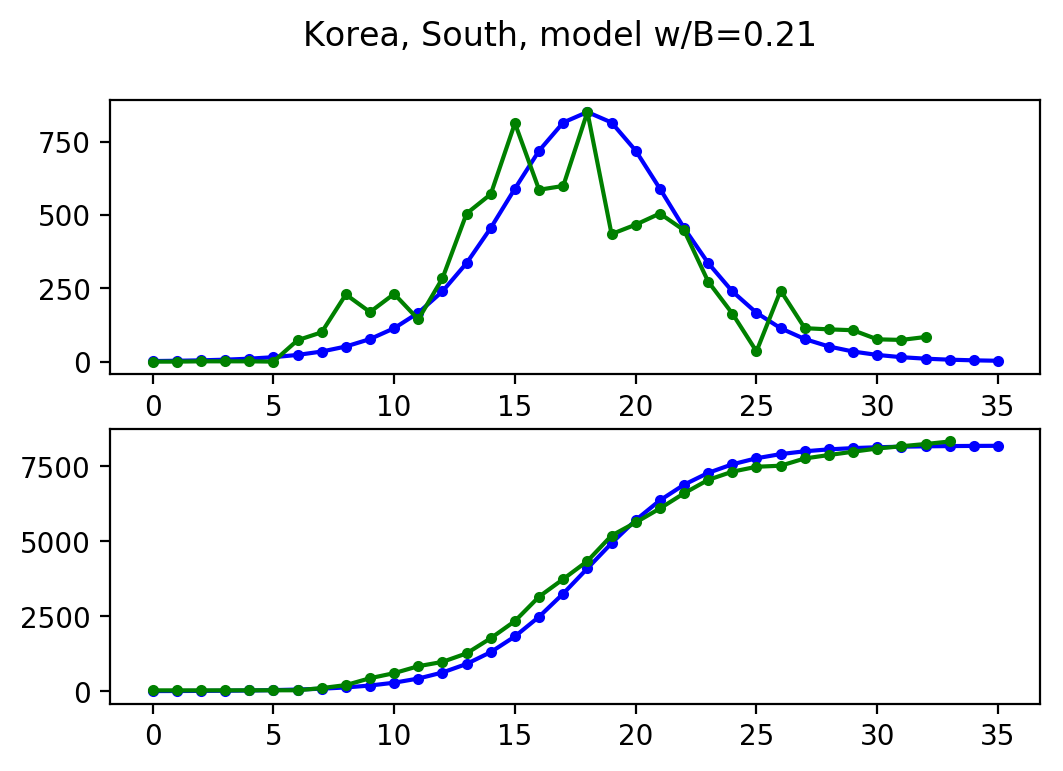

<Figure size 1200x800 with 0 Axes>

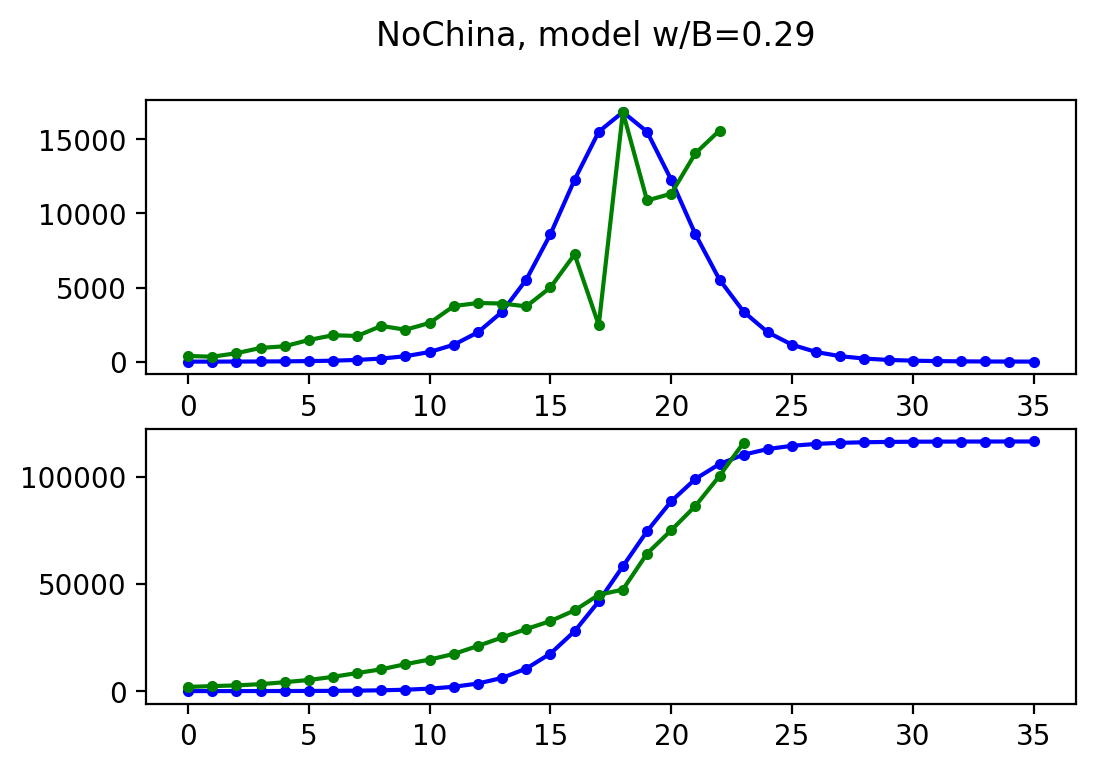

<Figure size 1200x800 with 0 Axes>

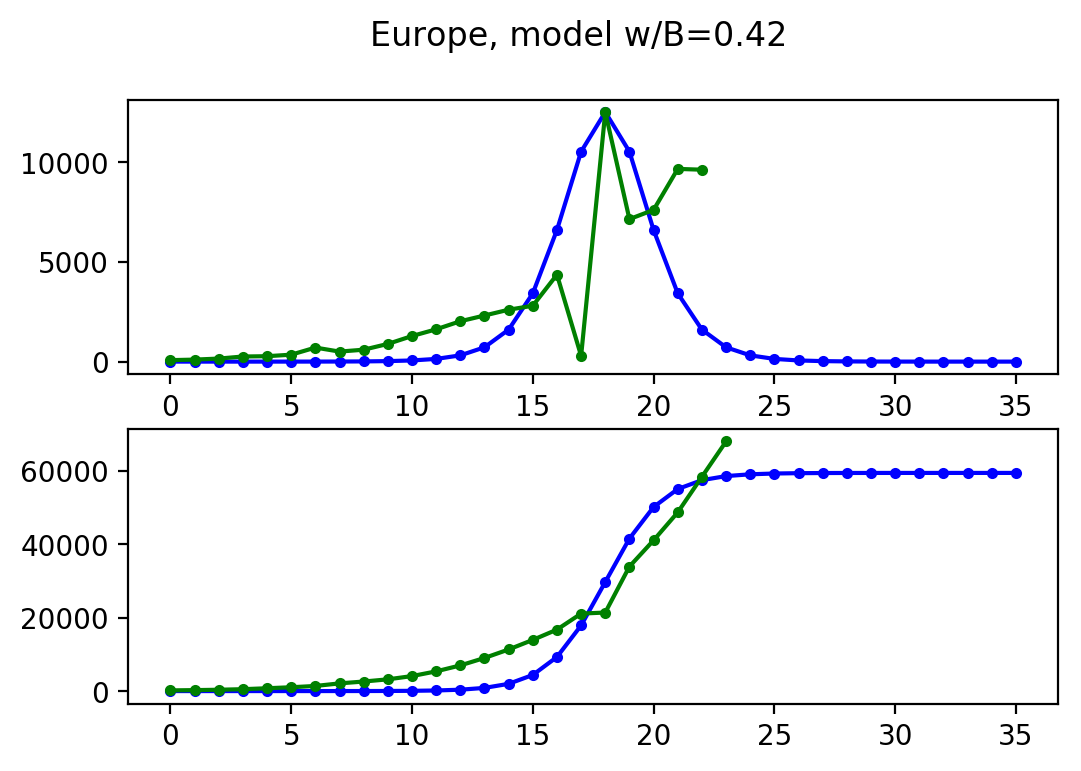

<Figure size 1200x800 with 0 Axes>

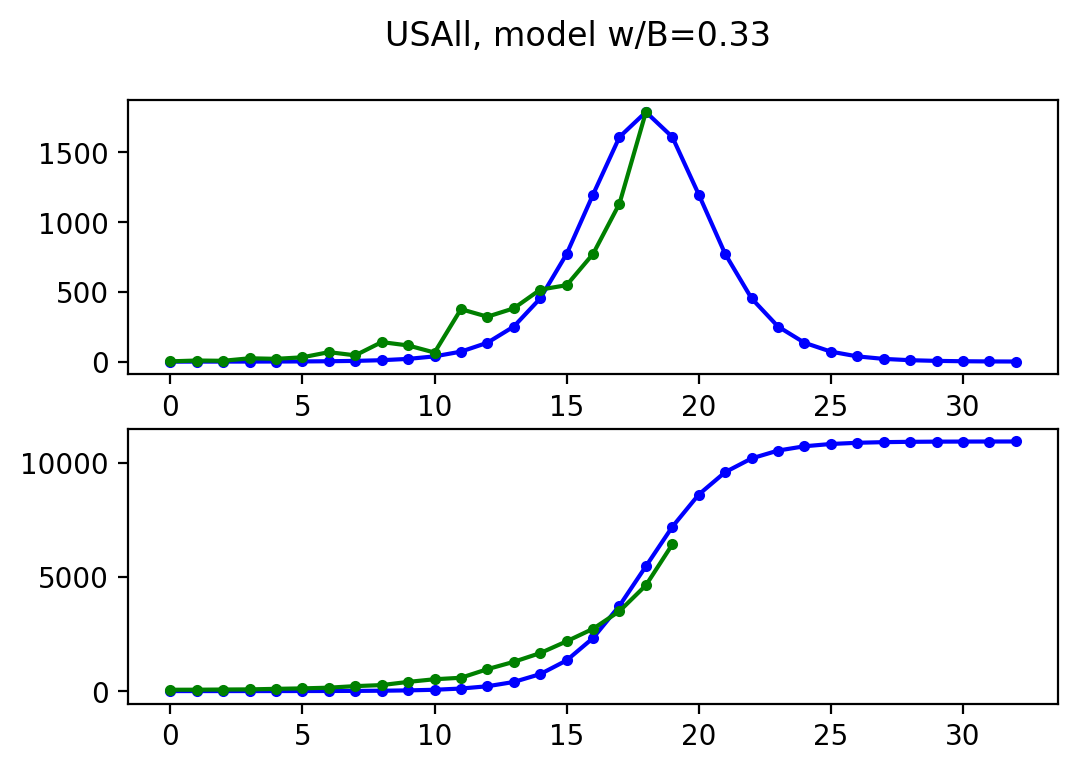

<Figure size 1200x800 with 0 Axes>

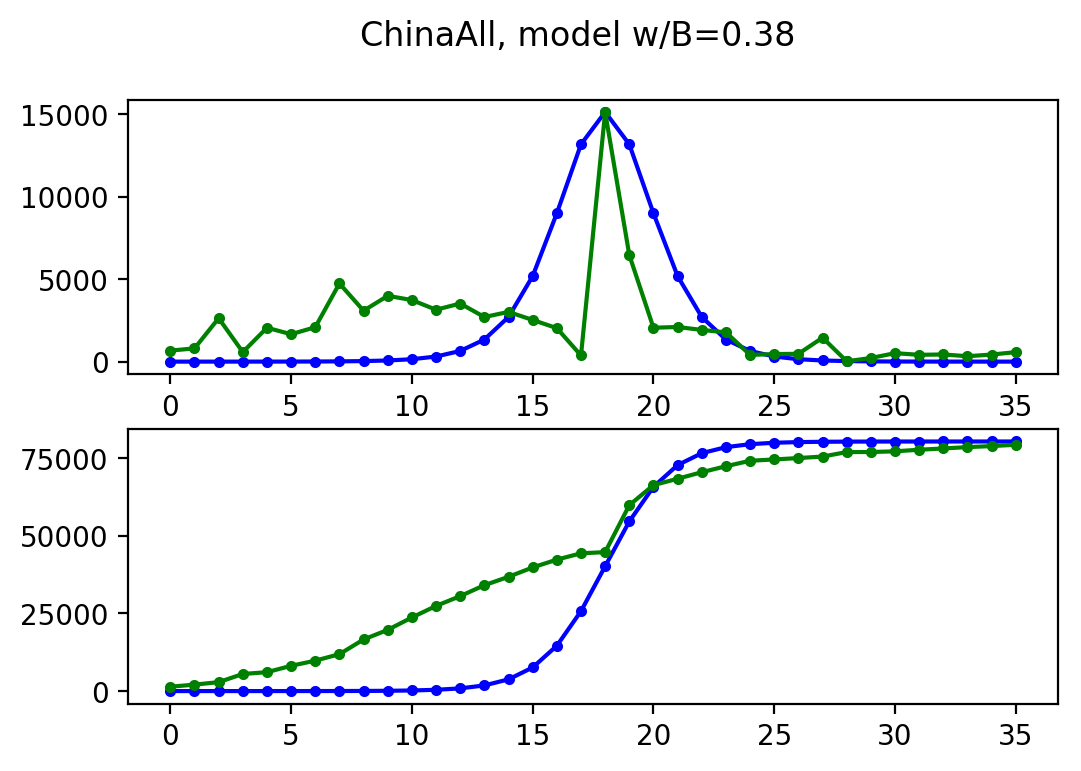

<Figure size 1200x800 with 0 Axes>

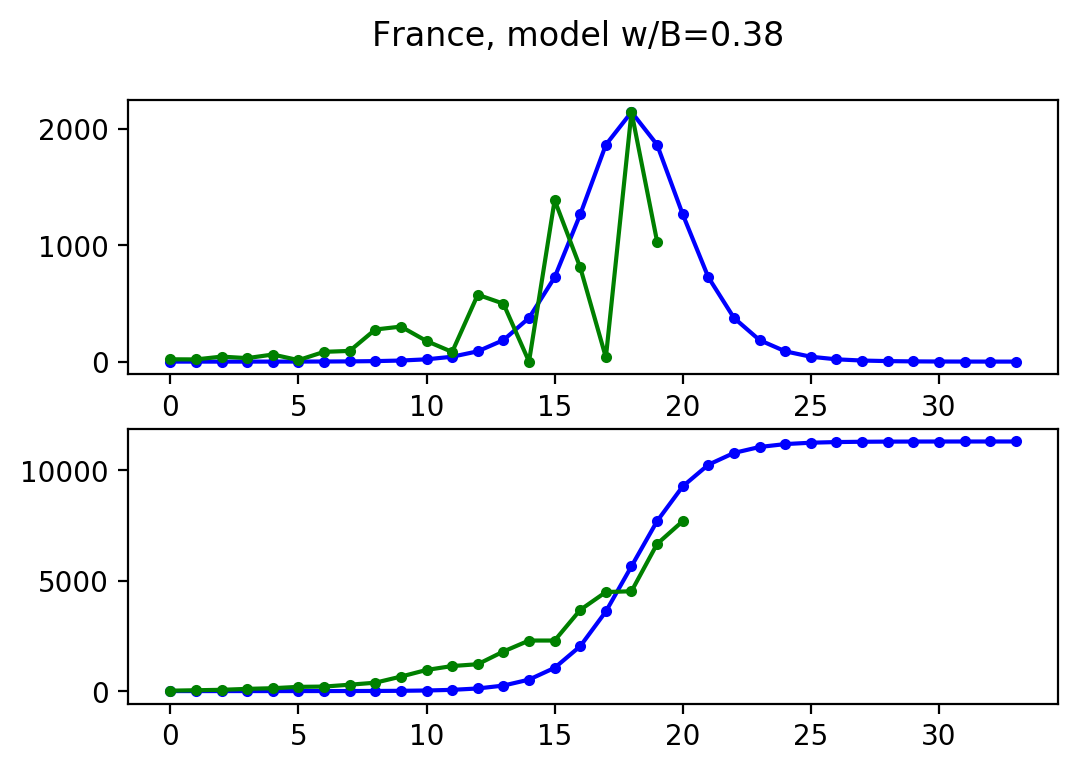

<Figure size 1200x800 with 0 Axes>

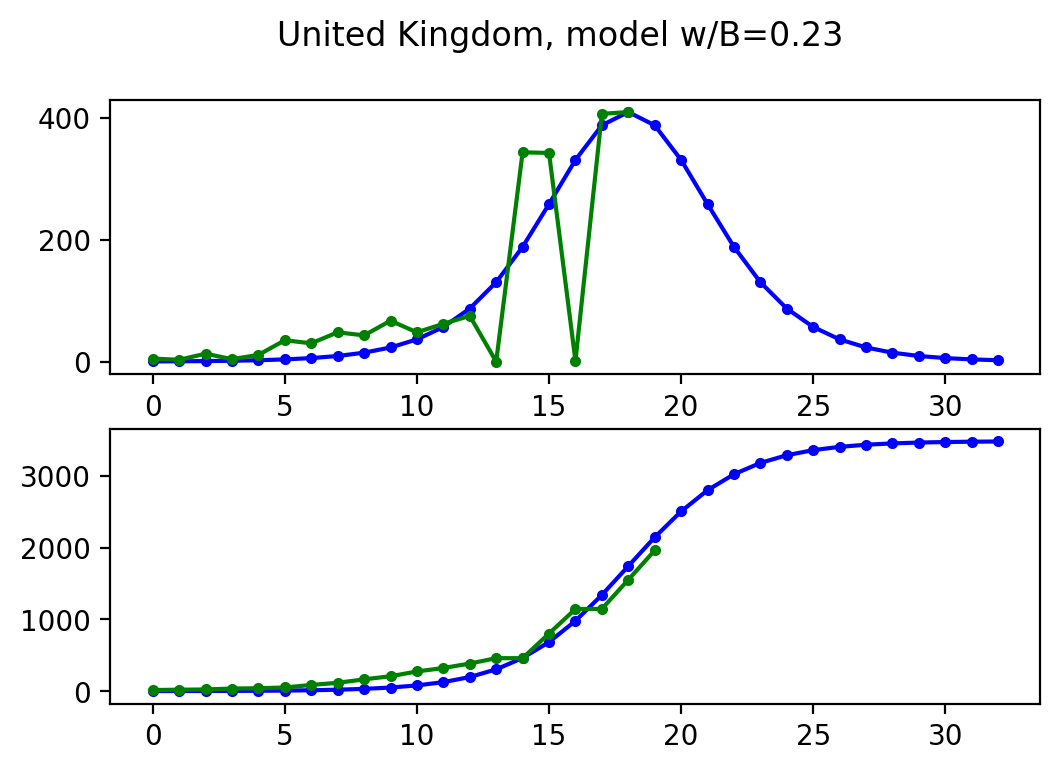

In [866]:
# place a model on all countries with high counts

for ctr in countriesFocused:
    plt.figure()
    # get daily change, drop first value, '0'
    v = data.loc[ctr].sum().diff().values[1:]
    y = data.loc[ctr].sum().values
    
    #A/C are derived, 
    A=max(v)
    C=np.argmax(v)
    # this is width variable, smaller means slower groth (this is a guss)
    # first run wiht a good set then adjust to target (for example run with south kora)
    def model(t,A,C,B):    
        return A/B * ( np.tanh( B * (t-C)) + 1 )
    f = lambda t,B: model(t, A, C,B)
    t = np.arange(0,sp.size(y))
    params, params_covariance = optimize.curve_fit(f, t, y,
                                               p0=[.2])
    
    B=params[0]
     
    #number of samples to plot is inversely releated to B
    M = 18# 2.5 weeks

    # must be in days
    N=sp.size(v)
    t = np.arange(0,N+14)
    yh = A/B * ( np.tanh( B * (t-C)) + 1 )

    vh = A/(np.cosh( B * (t-C))**2)
    fig, ax = plt.subplots(2,1,)
    label="%s, model w/B=%.2f" % (ctr,B)
    ax[0].plot(vh[C-M:C+M])
    ax[0].plot(v[C-M:C+M])
    fig.suptitle(label)
    ax[1].grid()
    ax[1].plot(yh[C-M:C+M])
    
    ax[1].plot(y[C-M:C+M])
    
    ax[1].grid()



        Germany 2020-03-06:-9
          Italy 2020-02-27:-1
          Spain 2020-03-08:-11
           Iran 2020-02-29:-3
   Korea, South 2020-02-23:3
         France 2020-03-06:-9
        NoChina 2020-02-14:12
         Europe 2020-02-26:0
          USAll 2020-03-08:-11
       ChinaAll 2020-01-22:35


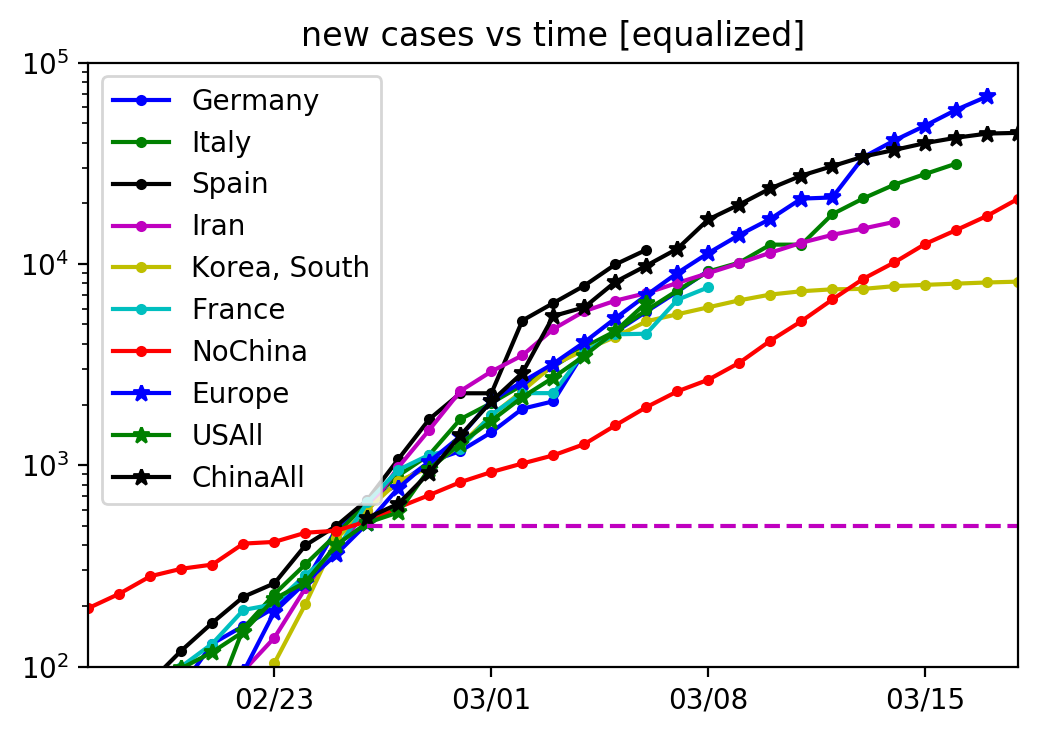

In [1043]:
#align countries, with the following offset to get a prediction where they are 
# ideally normalize too

offsets = {"ChinaAll":31,
           "Italy":-9,
           "Spain":-15,
           "Iran":-8,
           "Germany":-15,
           "Korea, South":-5,
           "Switzerland":-16,
           "France":-15,
           "NoChina":0,
           "Europe":-5,
           "Norway":-20,
           "United Kingdom":-20,
           "USAll":-20}

N= 500;# number of sample to align too
M= 5000;# minimum case count
# find reference time stamp of passing N samples                  
idx = pd.IndexSlice
id = np.argmax((dataJHU.loc[idx["Europe",:,:,:],:]> N).values[0]==True)
dtRef = dataJHU.columns[id]

#plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgbcmyk') +"
#                                   "cycler('lw', [1, 1, 3])")
                  
fig, ax=plt.subplots(1,1)
#only consider countires with large number of cases
for index, row in dataJHU[dataJHU[dt]>M].iterrows():
    ctr =index[0]
    #print(ctr)
    if("China" == ctr): continue
    #equalize start data to be at N cases and to ref country (US)
    dtg = row[row>N].first_valid_index()
    do  = datetime.timedelta((dtRef - dtg).days)
    print("%15s %s:%d"%(ctr,dtg.date(),do.days))
    #do  =datetime.timedelta(days=offsets[ctr])
    vdt = [(d +do).date()#.strftime("%m/%d")
           for d in dataJHU.columns]
    
    ax.semilogy(vdt,row.values, label=ctr)
ax.semilogy(vdt,np.ones(56) * N, '--')    
#ax.xaxis.set_major_locator(myLocator)
ax.grid()
#control range to zoom regio of interest
ax.set_ylim(1e2, 1e5)
ax.set_xlim(datetime.date(2020, 2, 17), datetime.date.today())
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("new cases vs time [equalized]");



In [1039]:
print(dataJHU.loc["NoChina"].values)
print(dataJHU.loc["Korea, South"].values)
10**2

[[     7     10     21     28     43     50     69     79     93    125
     147    157    165    185    195    230    281    306    321    408
     416    462    473    527    617    711    824    925   1020   1120
    1273   1578   1943   2327   2659   3229   4154   5192   6655   8437
   10170  12579  14734  17345  21094  25051  28972  32701  37705  44944
   47411  64248  75120  86446 100497 116087]]
[[   1    1    2    2    3    4    4    4    4   11   12   15   15   16
    19   23   24   24   25   27   28   28   28   28   28   29   30   31
    31  104  204  433  602  833  977 1261 1766 2337 3150 3736 4335 5186
  5621 6088 6593 7041 7314 7478 7513 7755 7869 7979 8086 8162 8236 8320]]


100

             model     cdc     jhu
2020-02-26    1412   282.5    57.0
2020-02-27    1592   323.5    58.0
2020-02-28    1795   384.5    60.0
2020-02-29    2024   438.5    68.0
2020-03-01    2282   523.5    74.0
2020-03-02    2573   607.5    98.0
2020-03-03    2901   706.5   118.0
2020-03-04    3271   810.5   149.0
2020-03-05    3689   912.5   217.0
2020-03-06    4159  1014.5   262.0
2020-03-07    4689  1105.5   402.0
2020-03-08    5287  1210.5   518.0
2020-03-09    5961  1345.5   583.0
2020-03-10    6721  1462.5   959.0
2020-03-11    7578  1549.5  1281.0
2020-03-12    8545  1594.5  1663.0
2020-03-13    9634  1621.5  2179.0
2020-03-14   10862  1631.5  2727.0
2020-03-15   12247  1641.5  3499.0
2020-03-16   13809  1651.5  4632.0
2020-03-17   15570  1661.5  6421.0
2020-03-18   17555  1671.5     NaN
2020-03-19   19793     NaN     NaN
2020-03-20   22317     NaN     NaN
2020-03-21   25162     NaN     NaN
2020-03-22   28370     NaN     NaN
2020-03-23   31988     NaN     NaN
2020-03-24   36066  

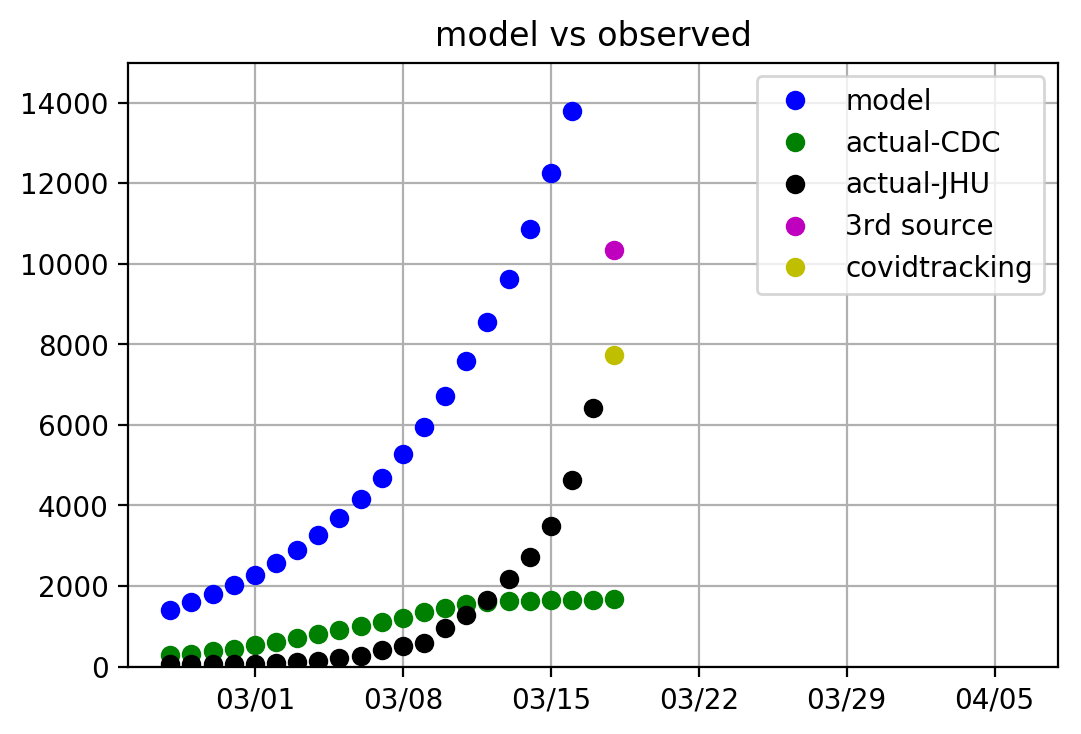

In [959]:
 #try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# use JHU
# estimate US data

idx = pd.IndexSlice

#find cumulateive greater then 50, this will be y0
startDate = dataCdc[dataCdc>250].index[0]
rate = .12

#start from scratch take y[0] and assume X% groth and assume, y0 was 20% report of all reporting (multiply by 5)
# get number of samples in the data base
N = (datetime.date.today()-startDate).days

#project for another 2 week
NP = 20
NEC = (datetime.date.today()    -dataCdc.index[-1]).days-1
NEJ = (datetime.datetime.today()-dataJHU.columns[-1] ).days-1


# projection (assume multipler of 5)
yh = dataCdc[startDate] * 5 * np.exp(rate * np.arange(0,N+NP))
yh=yh.astype(int)

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)

ax.plot_date(x,
             yh,
             label="model")
ax.plot_date(x[0:(N-NEC)],
             dataCdc[startDate:].values,
             label="actual-CDC")
ax.plot_date(x[0:(N-NEJ)],
             dataJHU.loc["US",startDate:].sum().values,
             label="actual-JHU")
ax.plot_date(datetime.date.today(),
             dataCS.loc[idx[:, :, :, "USA"],"cases"].sum(),
            label="3rd source")

ax.plot_date(datetime.date.today(),
        dataCovTr["positive"],
        label="covidtracking")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("model vs observed")
ax.set_ylim(0, 15000)


yc = np.concatenate([dataCdc.loc[startDate:].values,
                     np.nan * np.ones(NP+NEC)])


yj = np.concatenate([dataJHU.loc["US",startDate:].sum().values,
                    np.nan * np.ones(NP+NEJ)])



if(1):
    df =pd.DataFrame({"model": yh,
                  "cdc"  : yc,
                  "jhu"  : yj},index=x)
    print(df)


2020-02-08 00:00:00


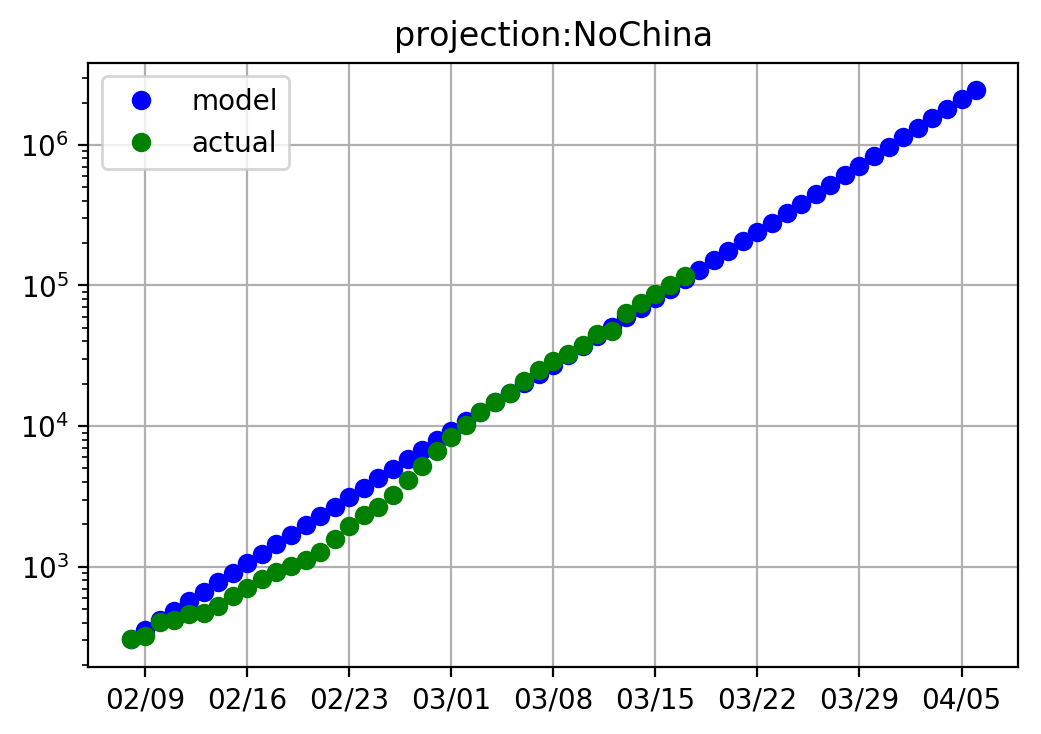

In [869]:
# try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# https://en.wikipedia.org/wiki/Generalised_logistic_function
# assuming a groth rate of 10%
#where will the us be
#start date
rate      = .155
ctr       = "NoChina"
caseMin   = 300
TN        = 21     # number of intervals after today



s = data.loc[ctr].sum()
startDate = s[s>caseMin].index[0]

print(startDate)

#nmber of intervals
N  = sp.size(data.columns)


# Set the epoch value
Y0 = data[startDate][ctr].sum()
#determine time offset
offset = (data.columns[-1]-startDate).days
Yt =Y0 * sp.exp(rate * np.arange(0,offset + TN))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,offset + TN)]
NE = (datetime.datetime.today()-data.columns[-1] ).days


fig,ax = plt.subplots(1,1)
ax.plot_date(x,
             Yt,
             label="model")



ax.plot_date(x[:(offset+NE)],
             data.loc[ctr,startDate:].sum(),
             label="actual")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection:%s"%ctr)
#ax.set_ylim(0, 50000)
plt.yscale('log')



In [981]:
#script for scraping HTML sites 
# investigate  java scripts for cleaner solution, need to inspect and find source
import re,pickle, requests
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install packaging
    from bs4 import BeautifulSoup


URL = 'https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')




table = soup.find("div",{"class":"table parbase section"})
rows = table.find_all('tr')

# handle header
header = [row.text for row in rows[1].find_all('td')]
header = [re.sub('[ \t\n]+', ' ',h)  for h in header]

tbl ={}
for row in rows[2:]: #skip the first row
    data = [r.text for r in row.find_all('td')]    
    if data[1] =='\xa0':continue    
    tbl[data[0]]=[int(d) for d in data[1:]]
df = pd.DataFrame(tbl, index=header[1:])
display(HTML(df.to_html()))
updateDateTime = rows[0].find('td').text.split('\n')[-1].replace("Updated","")
print("last update is%s" % updateDateTime )

dt = datetime.datetime.strptime(updateDateTime.strip(),"%B %d, %Y")
# get data
data = pickle.load( open( "sandiego.tseries.p", "rb" ) )
if not dt in data.keys():
    print("saving new data, with key %s" %dt)
    data[dt] =df
    pickle.dump(data,open("sandiego.tseries.p",'wb'))

,Total Positives,0-17 years,18-64 years,65+ years,Age Unknown,Female,Male,Unknown,Hospitalized,Deaths
San Diego County Residents,51,0,43,8,0,17,34,0,8,0
Federal Quarantine,5,0,1,4,0,2,3,0,1,0
Non-San Diego County Residents,4,0,3,1,0,2,2,0,1,0
Total,60,0,47,13,0,21,39,0,10,0


last update is March 17, 2020 


In [896]:
data = pickle.load(open("sandiego.tseries.p",'rb'))
#specify data to access
dt = datetime.datetime(2020, 3, 17, 0, 0)
data[dt]


,Total Positives,0-17 years,18-64 years,65+ years,Age Unknown,Female,Male,Unknown,Hospitalized,Deaths
San Diego County Residents,51,0,43,8,0,17,34,0,8,0
Federal Quarantine,5,0,1,4,0,2,3,0,1,0
Non-San Diego County Residents,4,0,3,1,0,2,2,0,1,0
Total,60,0,47,13,0,21,39,0,10,0
